In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PINN_HeatEquation(nn.Module):
    def __init__(self):
        super(PINN_HeatEquation, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 50),  # Entrée: (x, y, t)
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 1)   # Sortie: u(x, y, t)
        )

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        return self.fc(inputs)


In [155]:
def loss_heat_eq(x, y, t, pred, alpha=0.03):
    du_dt = torch.autograd.grad(pred, t, grad_outputs=torch.ones_like(pred, requires_grad=True), create_graph=True, retain_graph=True)[0]
    
    du_dx = torch.autograd.grad(pred, x, grad_outputs=torch.ones_like(pred), create_graph=True, retain_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

    du_dy = torch.autograd.grad(pred, y, grad_outputs=torch.ones_like(pred), create_graph=True, retain_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0]

    physics_loss = torch.mean((du_dt - alpha * (d2u_dx2 + d2u_dy2)) ** 2)
    return physics_loss + torch.mean(torch.abs(torch.autograd.grad(pred, t, grad_outputs=torch.ones_like(pred), create_graph=True)[0]))



def loss_initial_condition(x, y, u_initial, model):
    t_zero = torch.zeros_like(x)  # t = 0
    u_pred = model(x, y, t_zero)
    return torch.mean((u_pred - u_initial) ** 2)

def loss_boundary_condition(x_boundary, y_boundary, t_boundary, model):
    u_pred = model(x_boundary, y_boundary, t_boundary)
    u_pred_boundary = torch.cat([u_pred[0,:], u_pred[-1,:], u_pred[:,0].T, u_pred[:,-1].T])  
    return torch.mean(u_pred_boundary ** 2)  # Pénalise si u ≠ 0 aux bords

In [156]:
def generate_collocation_points(num_points=10000, T_max=5):
    X = torch.rand(num_points, 1, requires_grad=True)  # x ∈ [0,1]
    Y = torch.rand(num_points, 1, requires_grad=True)  # y ∈ [0,1]
    T = torch.rand(num_points, 1, requires_grad=True) * T_max  # t ∈ [0,T_max]
    return X, Y, T

In [157]:
def train_pinn_heat(model, X_train, Y_train, T_train, U_initial, X_boundary, Y_boundary, T_boundary, alpha=0.03, num_epochs=101, lr=0.001):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for epoch in range(num_epochs):

        optimizer.zero_grad()

        # Prédiction du modèle
        pred = model(X_train, Y_train, T_train)

        # Calcul des pertes
        physics_loss = loss_heat_eq(X_train, Y_train, T_train, pred, alpha)
        initial_loss = loss_initial_condition(X_train, Y_train, U_initial, model)
        boundary_loss = loss_boundary_condition(X_boundary, Y_boundary, T_boundary, model)

        # Pertes totales combinées
        total_loss = 2*physics_loss + 1.5*boundary_loss + initial_loss
        losses.append(total_loss.item())

        # Backpropagation
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item()}")

    # Affichage de la courbe de convergence
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Convergence du PINN pour l'équation de la chaleur")
    plt.show()

Epoch 0, Loss: 0.258675217628479
Epoch 100, Loss: 0.18375234305858612
Epoch 200, Loss: 0.18247851729393005
Epoch 300, Loss: 0.1856115162372589
Epoch 400, Loss: 0.16125261783599854
Epoch 500, Loss: 0.14866498112678528
Epoch 600, Loss: 0.14295756816864014
Epoch 700, Loss: 0.1405603289604187
Epoch 800, Loss: 0.13751664757728577
Epoch 900, Loss: 0.1342202126979828
Epoch 1000, Loss: 0.13180463016033173
Epoch 1100, Loss: 0.13078534603118896
Epoch 1200, Loss: 0.13062486052513123
Epoch 1300, Loss: 0.1295599788427353
Epoch 1400, Loss: 0.12934164702892303
Epoch 1500, Loss: 0.12914112210273743
Epoch 1600, Loss: 0.12916289269924164
Epoch 1700, Loss: 0.12859511375427246
Epoch 1800, Loss: 0.12842535972595215
Epoch 1900, Loss: 0.12816178798675537
Epoch 2000, Loss: 0.12813322246074677
Epoch 2100, Loss: 0.12757916748523712
Epoch 2200, Loss: 0.1271394044160843
Epoch 2300, Loss: 0.1272953599691391
Epoch 2400, Loss: 0.1265282928943634
Epoch 2500, Loss: 0.12625601887702942
Epoch 2600, Loss: 0.1265168339014

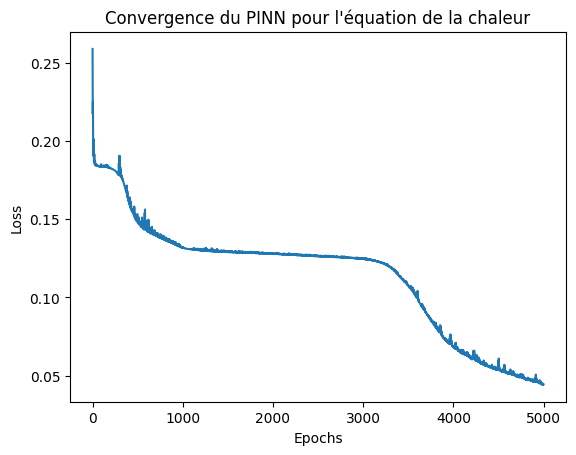

In [162]:
# 🔹 Création du modèle PINN
model = PINN_HeatEquation()

# 🔹 Génération des données
X_train, Y_train, T_train = generate_collocation_points()
U_initial = torch.sin(np.pi * X_train) * torch.sin(np.pi * Y_train)  # Condition initiale

X_boundary, Y_boundary, T_boundary = generate_collocation_points(1000)  # Points aux bords


# 🔹 Entraînement du modèle
train_pinn_heat(model, X_train, Y_train, T_train, U_initial, X_boundary, Y_boundary, T_boundary, num_epochs=5000)


In [163]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_test_grid(grid_size=30, T_values=[0, 1, 2, 3, 4, 5]):
    """
    Génère une grille régulière de (x, y) et des valeurs de temps (t) fixes.
    """
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)  # Grille régulière

    # Conversion en tensors PyTorch
    X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)
    Y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1)

    # Liste de tensors pour chaque instant t
    T_tensors = [torch.full_like(X_tensor, fill_value=t, dtype=torch.float32) for t in T_values]

    return X_tensor, Y_tensor, T_tensors, X, Y, T_values

def plot_heat_3D(model, grid_size=30, T_values=[0, 1, 2, 3, 4, 5]):
    """
    Affiche la diffusion thermique en 3D pour différents instants t.
    """
    model.eval()
    X_tensor, Y_tensor, T_tensors, X, Y, T_values = generate_test_grid(grid_size, T_values)

    fig = plt.figure(figsize=(15, 8))

    for i, T_tensor in enumerate(T_tensors):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')  # 2 lignes, 3 colonnes

        # Prédiction du modèle
        with torch.no_grad():
            U_pred = model(X_tensor, Y_tensor, T_tensor).cpu().numpy().reshape(X.shape)

        # 🔹 Affichage 3D
        ax.plot_surface(X, Y, U_pred, cmap='hot', edgecolor='none')

        # Labels et titre
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Température u(x,y,t)")
        ax.set_title(f"t = {T_values[i]}")

    plt.tight_layout()
    plt.show()


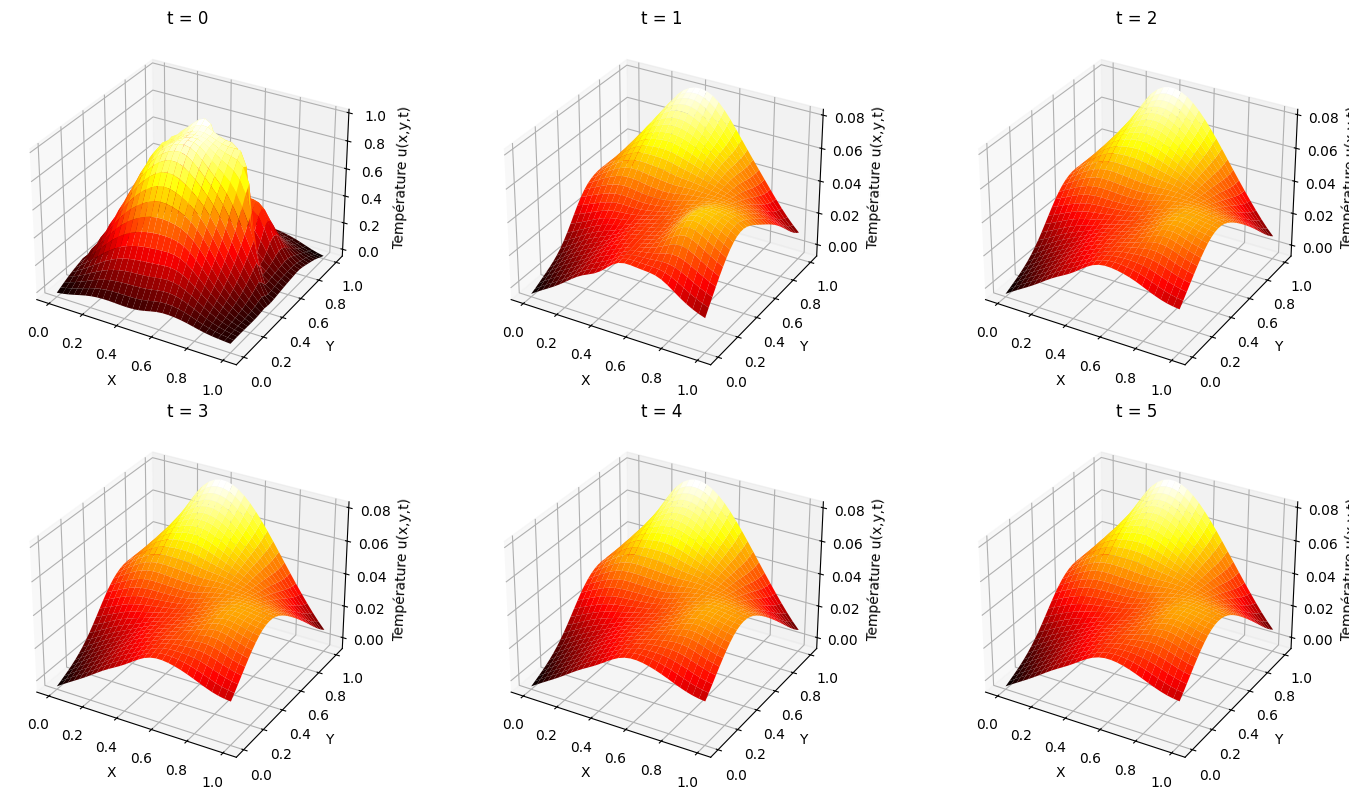

In [164]:

# 🔹 Visualisation
T_test = torch.linspace(0, 5, 10000).view(-1, 1)
# visualize_heat_diffusion(model, X_train, Y_train, T_test)
plot_heat_3D(model, grid_size=30, T_values=[0, 1, 2, 3, 4, 5])

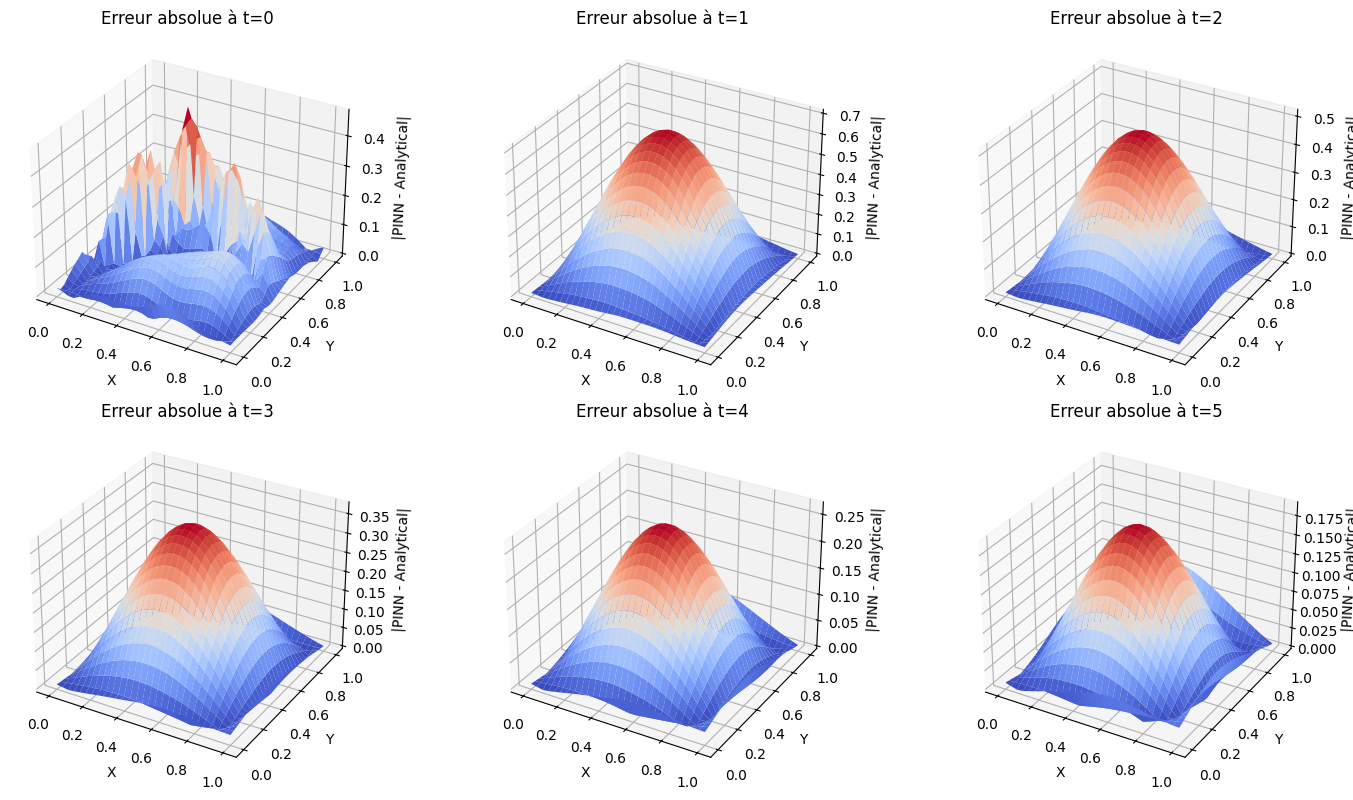

In [166]:
import numpy as np

def analytical_solution(x, y, t, alpha=0.03):
    """
    Calcule la solution analytique de l'équation de la chaleur en 2D.
    """
    return np.exp(-np.pi**2 * alpha * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

import torch
import matplotlib.pyplot as plt

def compare_pinn_vs_analytical(model, grid_size=30, T_values=[0, 1, 2, 3, 4, 5], alpha=0.03):
    """
    Compare la solution du PINN avec la solution analytique et affiche l'erreur.
    """
    model.eval()
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)

    X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)
    Y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1)

    fig = plt.figure(figsize=(15, 8))

    for i, t in enumerate(T_values):
        T_tensor = torch.full_like(X_tensor, fill_value=t, dtype=torch.float32)

        # 🔹 Solution analytique
        U_exact = analytical_solution(X.flatten(), Y.flatten(), t, alpha).reshape(X.shape)

        # 🔹 Solution PINN
        with torch.no_grad():
            U_pinn = model(X_tensor, Y_tensor, T_tensor).cpu().numpy().reshape(X.shape)

        # 🔹 Calcul de l'erreur absolue
        error = np.abs(U_pinn - U_exact)

        # 🔸 Affichage en 3D
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        ax.plot_surface(X, Y, error, cmap='coolwarm', edgecolor='none')

        # Labels et titre
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("|PINN - Analytical|")
        ax.set_title(f"Erreur absolue à t={t}")

    plt.tight_layout()
    plt.show()


    
compare_pinn_vs_analytical(model, grid_size=30, T_values=[0, 1, 2, 3, 4, 5], alpha=0.03)
